# **Advance Data Processing**
<hr>

| Name | AdminNo |
| :--: | :-----: |
| Goh Pin Pin Isaac     | P2317623 |
| Adam Bin Roslan       | P2317425 |
| Choy Jee Hung Caleb   | P2341475 |
| Thor Hui Qin          | P2309219 |

- **Class:** DAAA/FT/2A/23
- **Module Code:** ST1508 Practical AI
<hr>

## Project Objective **(Phase 2)**
- `Train a model` and `create an application` to predict whether a new order is a fraud or not. 
- The application is to be used internally in the company by the operation team to identify fraud orders and take early pro-active actions accordingly.

<br>
<hr>

## Advance Data Processing Techniques
- <u>**Outlier Detection Techniques**</u>
    - To identify data points that deviate significantly from the majority of the data. These anomalies may represent:
        - `Errors`: Mistakes in data entry, sensor glitches, or corrupted files.
        - `Rare Events`: Genuine but infrequent phenomena, such as fraud, cybersecurity breaches, or rare medical conditions.
        - `Special Cases`: Edge cases that may indicate underlying patterns or new insights.
- <u>**Imbalanced Classes Techniques**</u>
    - To handle datasets where one class **significantly outweighs** others in terms of frequency. This imbalance can cause machine learning models to perform poorly on the minority class, which is often the one we care most about, for our case (Fraud Orders)!
<br>
<hr>

# **Importing Libaries**

In [1]:
# Importing Modules
import pandas as pd
import numpy as np
from numpy import percentile
from tqdm import tqdm
from sqlalchemy import create_engine, text

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sklearn
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, make_scorer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import defaultdict
import time


# Warnings
import warnings
warnings.filterwarnings('ignore')

# **Extract, Load & Transform**

In [2]:
server = 'PINPINPC\\SQLEXPRESS'
database = 'SP-buy'
engine = create_engine(f'mssql+pyodbc://{server}/{database}?driver=SQL+Server')

# Function to retrieve data from a specific table and return a DataFrame
def get_table_data(table_name):
    connection = engine.connect()
    query = text(f'SELECT * FROM {table_name}')
    result = connection.execute(query)
    df = pd.DataFrame(data=result.fetchall(), columns=result.keys())
    connection.close()
    return df

# Retrieve data from each table
customers_df = get_table_data('customers')
orders_df = get_table_data('orders')
order_labels_df = get_table_data('order_labels')

In [3]:
# ===================== Customer Features Data =====================
customers_df['total_payment_last_50days'] = pd.to_numeric(customers_df['total_payment_last_50days'], errors='coerce')
customers_df['mobile_verified'] = customers_df['mobile_verified'].map({'True': True, 'False': False})
customers_df['mobile_verified'] = customers_df['mobile_verified'].astype(bool)
customers_df['country_code'] = customers_df['country_code'].astype('category')
customers_df['customer_id'] = customers_df['customer_id'].astype('category')
customers_df['num_orders_last_50days'] = customers_df['num_orders_last_50days'].astype('int16')
customers_df['num_cancelled_orders_last_50days'] = customers_df['num_cancelled_orders_last_50days'].astype('int16')
customers_df['num_refund_orders_last_50days'] = customers_df['num_refund_orders_last_50days'].astype('int16')
customers_df['num_associated_customers'] = customers_df['num_associated_customers'].astype('int16')
customers_df['total_payment_last_50days'] = customers_df['total_payment_last_50days'].astype('float32')

# ===================== Order Features Data =====================
orders_df['order_value'] = pd.to_numeric(orders_df['order_value'], errors='coerce')
orders_df['refund_value'] = pd.to_numeric(orders_df['refund_value'], errors='coerce')
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'], errors='coerce')
orders_df['country_code'] = orders_df['country_code'].astype('category')
orders_df['order_id'] = orders_df['order_id'].astype('category')
orders_df['collect_type'] = orders_df['collect_type'].astype('category')
orders_df['payment_method'] = orders_df['payment_method'].astype('category')
orders_df['num_items_ordered'] = orders_df['num_items_ordered'].astype('int16')
orders_df['order_value'] = orders_df['order_value'].astype('float32')
orders_df['refund_value'] = orders_df['refund_value'].astype('float32')
orders_df['order_date'] = pd.to_datetime(orders_df['order_date']).dt.normalize()

# ===================== Order Label Data ====================
order_labels_df['country_code'] = order_labels_df['country_code'].astype('category')
order_labels_df['order_id'] = order_labels_df['order_id'].astype('category')
order_labels_df['customer_id'] = order_labels_df['customer_id'].astype('category')

### **Feature Engineering**
<hr>

##### Grouping Payment Methods
- Group 1: `Credit/Debit Card Payments`
    - cybersource creditcard: 324,605
    - credit card: 270,693
    - generic creditcard: 172,853
    - cybersource applepay: 1,359
- Group 2: `Online Banking`
    - razer online banking: 298,750
    - xendit directdebit: 8
- Group 3: `Digital Wallets`
    - antfinancial gcash: 246,217
    - antfinancial tng: 51,773
    - antfinancial bkash: 42,249
    - antfinancial truemoney: 22,060
    - adyen hpp boost: 14,608
    - jazzcash wallet: 5,846
    - paypal: 852
- Group 4: `Buy Now, Pay Later`
    - invoice: 4,912
- Group 5: `Preloaded Balance`
    - balance: 61,859
- Group 6: `Cash/Alternative Payments`
    - payment on delivery: 747,245
    - no payment: 1,624
- Group 7: `Other Payment Gateways`
    - adyen hpp molpay: 1,883


In [4]:
payment_groups = {
    # Credit/Debit Card Payments
    "cybersource creditcard": "Credit/Debit Card Payments",
    "credit card": "Credit/Debit Card Payments",
    "generic creditcard": "Credit/Debit Card Payments",
    "cybersource applepay": "Credit/Debit Card Payments",
    
    # Online Banking
    "razer online banking": "Online Banking",
    "xendit directdebit": "Online Banking",
    
    # Digital Wallets
    "antfinancial gcash": "Digital Wallets",
    "antfinancial tng": "Digital Wallets",
    "antfinancial bkash": "Digital Wallets",
    "antfinancial truemoney": "Digital Wallets",
    "adyen hpp boost": "Digital Wallets",
    "jazzcash wallet": "Digital Wallets",
    "paypal": "Digital Wallets",
    
    # Buy Now, Pay Later
    "invoice": "Buy Now, Pay Later",
    
    # Preloaded Balance
    "balance": "Preloaded Balance",
    
    # Cash/Alternative Payments
    "payment on delivery": "Cash/Alternative Payments",
    "no payment": "Cash/Alternative Payments",
    
    # Other Payment Gateways
    "adyen hpp molpay": "Other Payment Gateways"
}

# Add a new column for payment groups
orders_df['payment_group'] = orders_df['payment_method'].map(payment_groups)

### **Merge Dataset**
<hr>

In [5]:
pre_dataset = customers_df.merge(order_labels_df, left_on=['country_code', 'customer_id'], right_on=['country_code', 'customer_id'], how='inner')
sp_buy_dataset = pre_dataset.merge(orders_df, left_on=['country_code', 'order_id'], right_on=['country_code', 'order_id'], how='inner')
sp_buy_dataset

,country_code,customer_id,mobile_verified,num_orders_last_50days,num_cancelled_orders_last_50days,num_refund_orders_last_50days,total_payment_last_50days,num_associated_customers,first_order_datetime,order_id,is_fraud,collect_type,payment_method,order_value,num_items_ordered,refund_value,order_date,payment_group
0,BD,a0afp7hz,True,19,0,0,135.929993,3,2015-12-01 14:06:14,u2qo-f2n5,True,delivery,credit card,4.410000,5,0.00,2023-04-08,Credit/Debit Card Payments
1,BD,a0akr6uc,True,31,1,0,312.239990,2,2017-09-13 08:26:51,orca-073r,False,delivery,payment on delivery,1.230000,3,0.53,2023-02-17,Cash/Alternative Payments
2,BD,a0aya4cb,True,34,0,0,381.790009,3,2016-02-29 13:45:03,u7ox-r80t,False,delivery,payment on delivery,5.670000,3,2.03,2023-04-28,Cash/Alternative Payments
3,BD,a0bwh4cs,True,51,0,0,611.809998,1,2015-12-16 16:08:34,fgxo-yub4,False,delivery,credit card,4.870000,7,0.00,2023-04-03,Credit/Debit Card Payments
4,BD,a0bwh4cs,True,51,0,0,611.809998,1,2015-12-16 16:08:34,ta7z-z366,False,delivery,antfinancial bkash,7.550000,3,3.92,2023-05-08,Digital Wallets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263675,TH,z9vaf2ti,True,6,0,0,217.619995,2,2015-10-20 11:23:09,w1ep-tjlo,False,delivery,cybersource creditcard,10.580000,2,11.48,2023-04-27,Credit/Debit Card Payments
2263676,TH,z9xql6cq,True,5,0,0,175.190002,1,2015-08-18 15:10:01,d9dy-0mpg,False,delivery,cybersource creditcard,15.800000,2,0.00,2022-11-13,Credit/Debit Card Payments
2263677,TH,z9xwq4yl,True,1,0,0,28.570000,2,2020-09-26 13:20:08,a6kp-u64i,False,delivery,cybersource creditcard,4.340000,1,0.00,2023-05-09,Credit/Debit Card Payments
2263678,TH,z9zra5st,True,39,0,0,677.440002,1,2017-03-27 12:23:57,d0ig-4eca,False,delivery,cybersource creditcard,5.800000,2,5.80,2023-02-06,Credit/Debit Card Payments


# **Univariate Outlier Analysis**

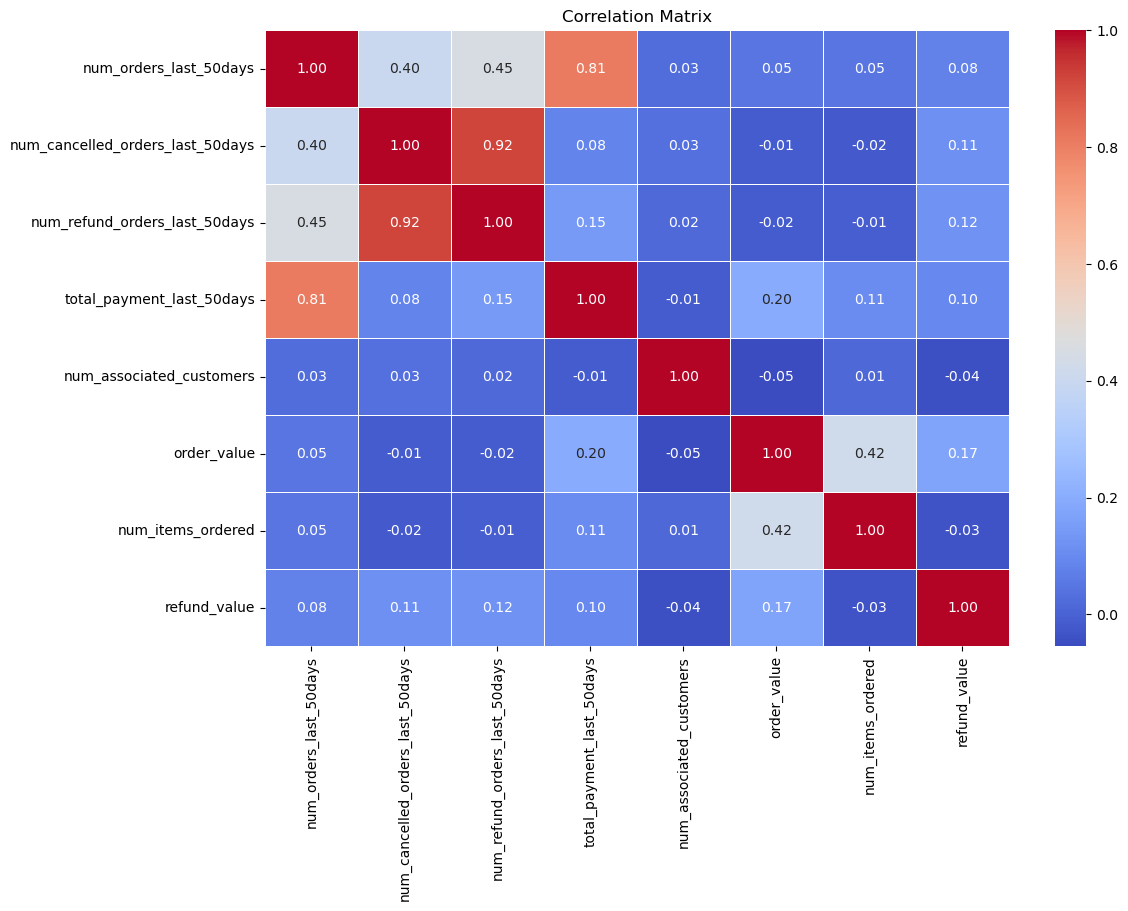

In [21]:
# Convert datetime columns to datetime type for consistency
sp_buy_dataset['first_order_datetime'] = pd.to_datetime(sp_buy_dataset['first_order_datetime'], errors='coerce')
sp_buy_dataset['order_date'] = pd.to_datetime(sp_buy_dataset['order_date'], errors='coerce')

# Select only numerical columns for correlation calculation
numerical_columns = sp_buy_dataset.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()

# Display the correlation matrix using seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

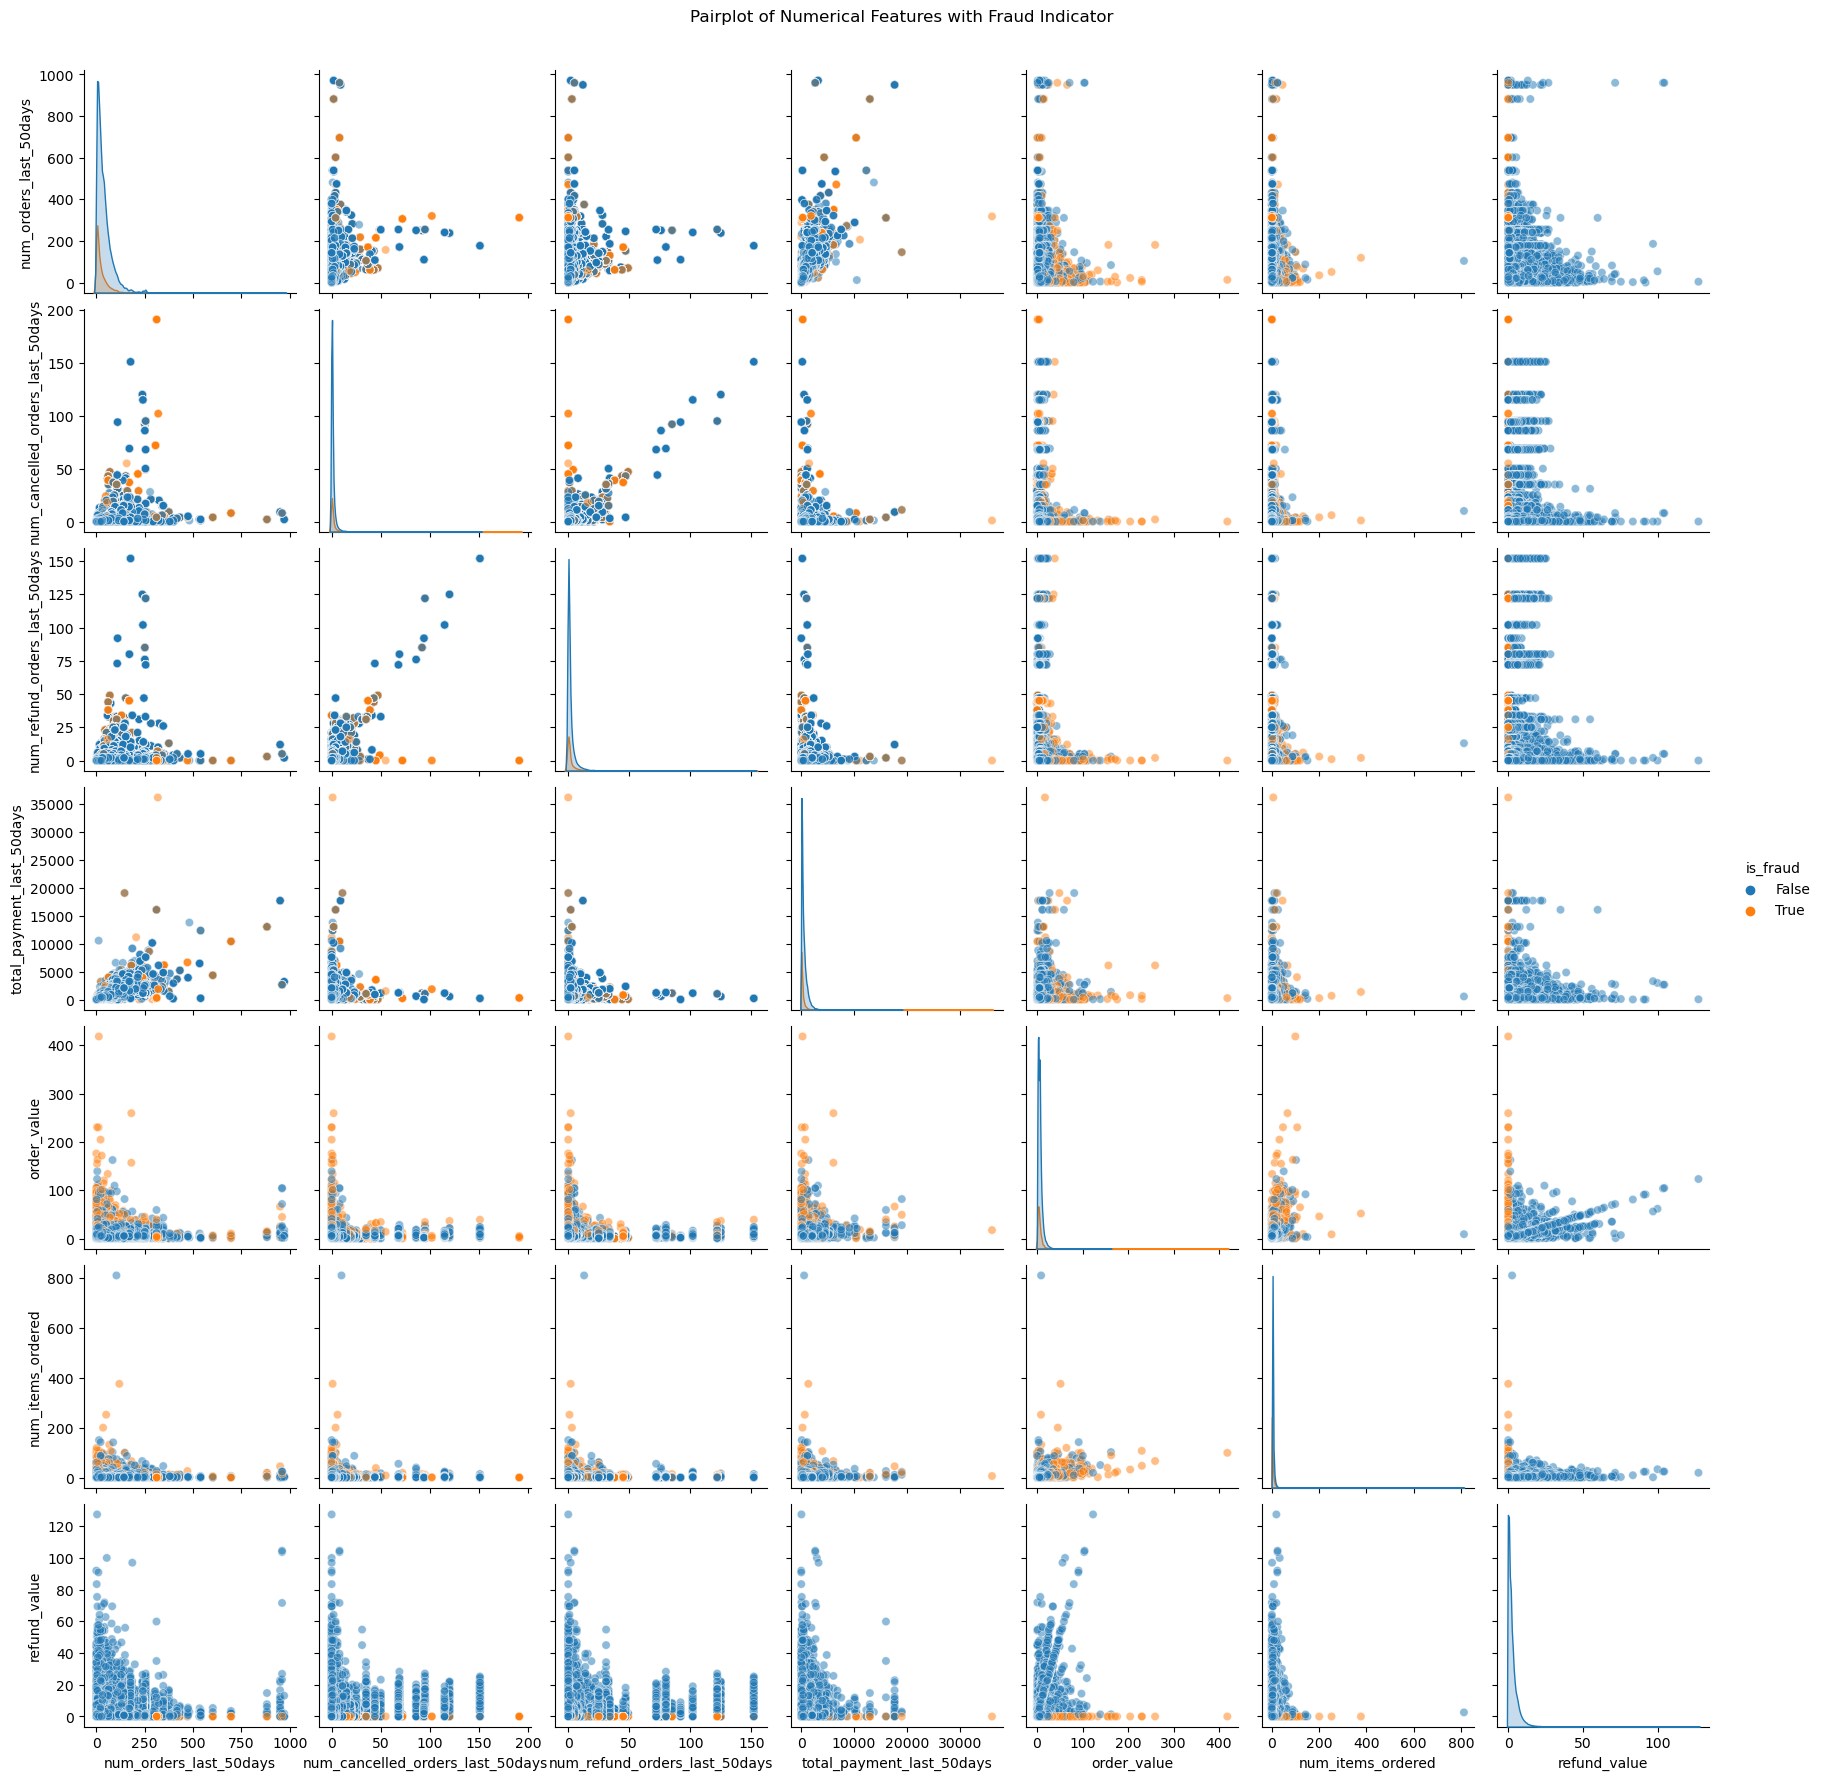

In [23]:
# Select relevant numerical columns
numerical_columns = [
    'num_orders_last_50days', 
    'num_cancelled_orders_last_50days', 
    'num_refund_orders_last_50days', 
    'total_payment_last_50days', 
    'order_value', 
    'num_items_ordered', 
    'refund_value'
]

# Filter the dataset for only the numerical columns and include the `is_fraud` column
pairplot_data = sp_buy_dataset[numerical_columns + ['is_fraud']]

# Create a pairplot with hue
sns.pairplot(pairplot_data, hue='is_fraud', diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Numerical Features with Fraud Indicator', y=1.02)  # Add a title above the plot
plt.show()

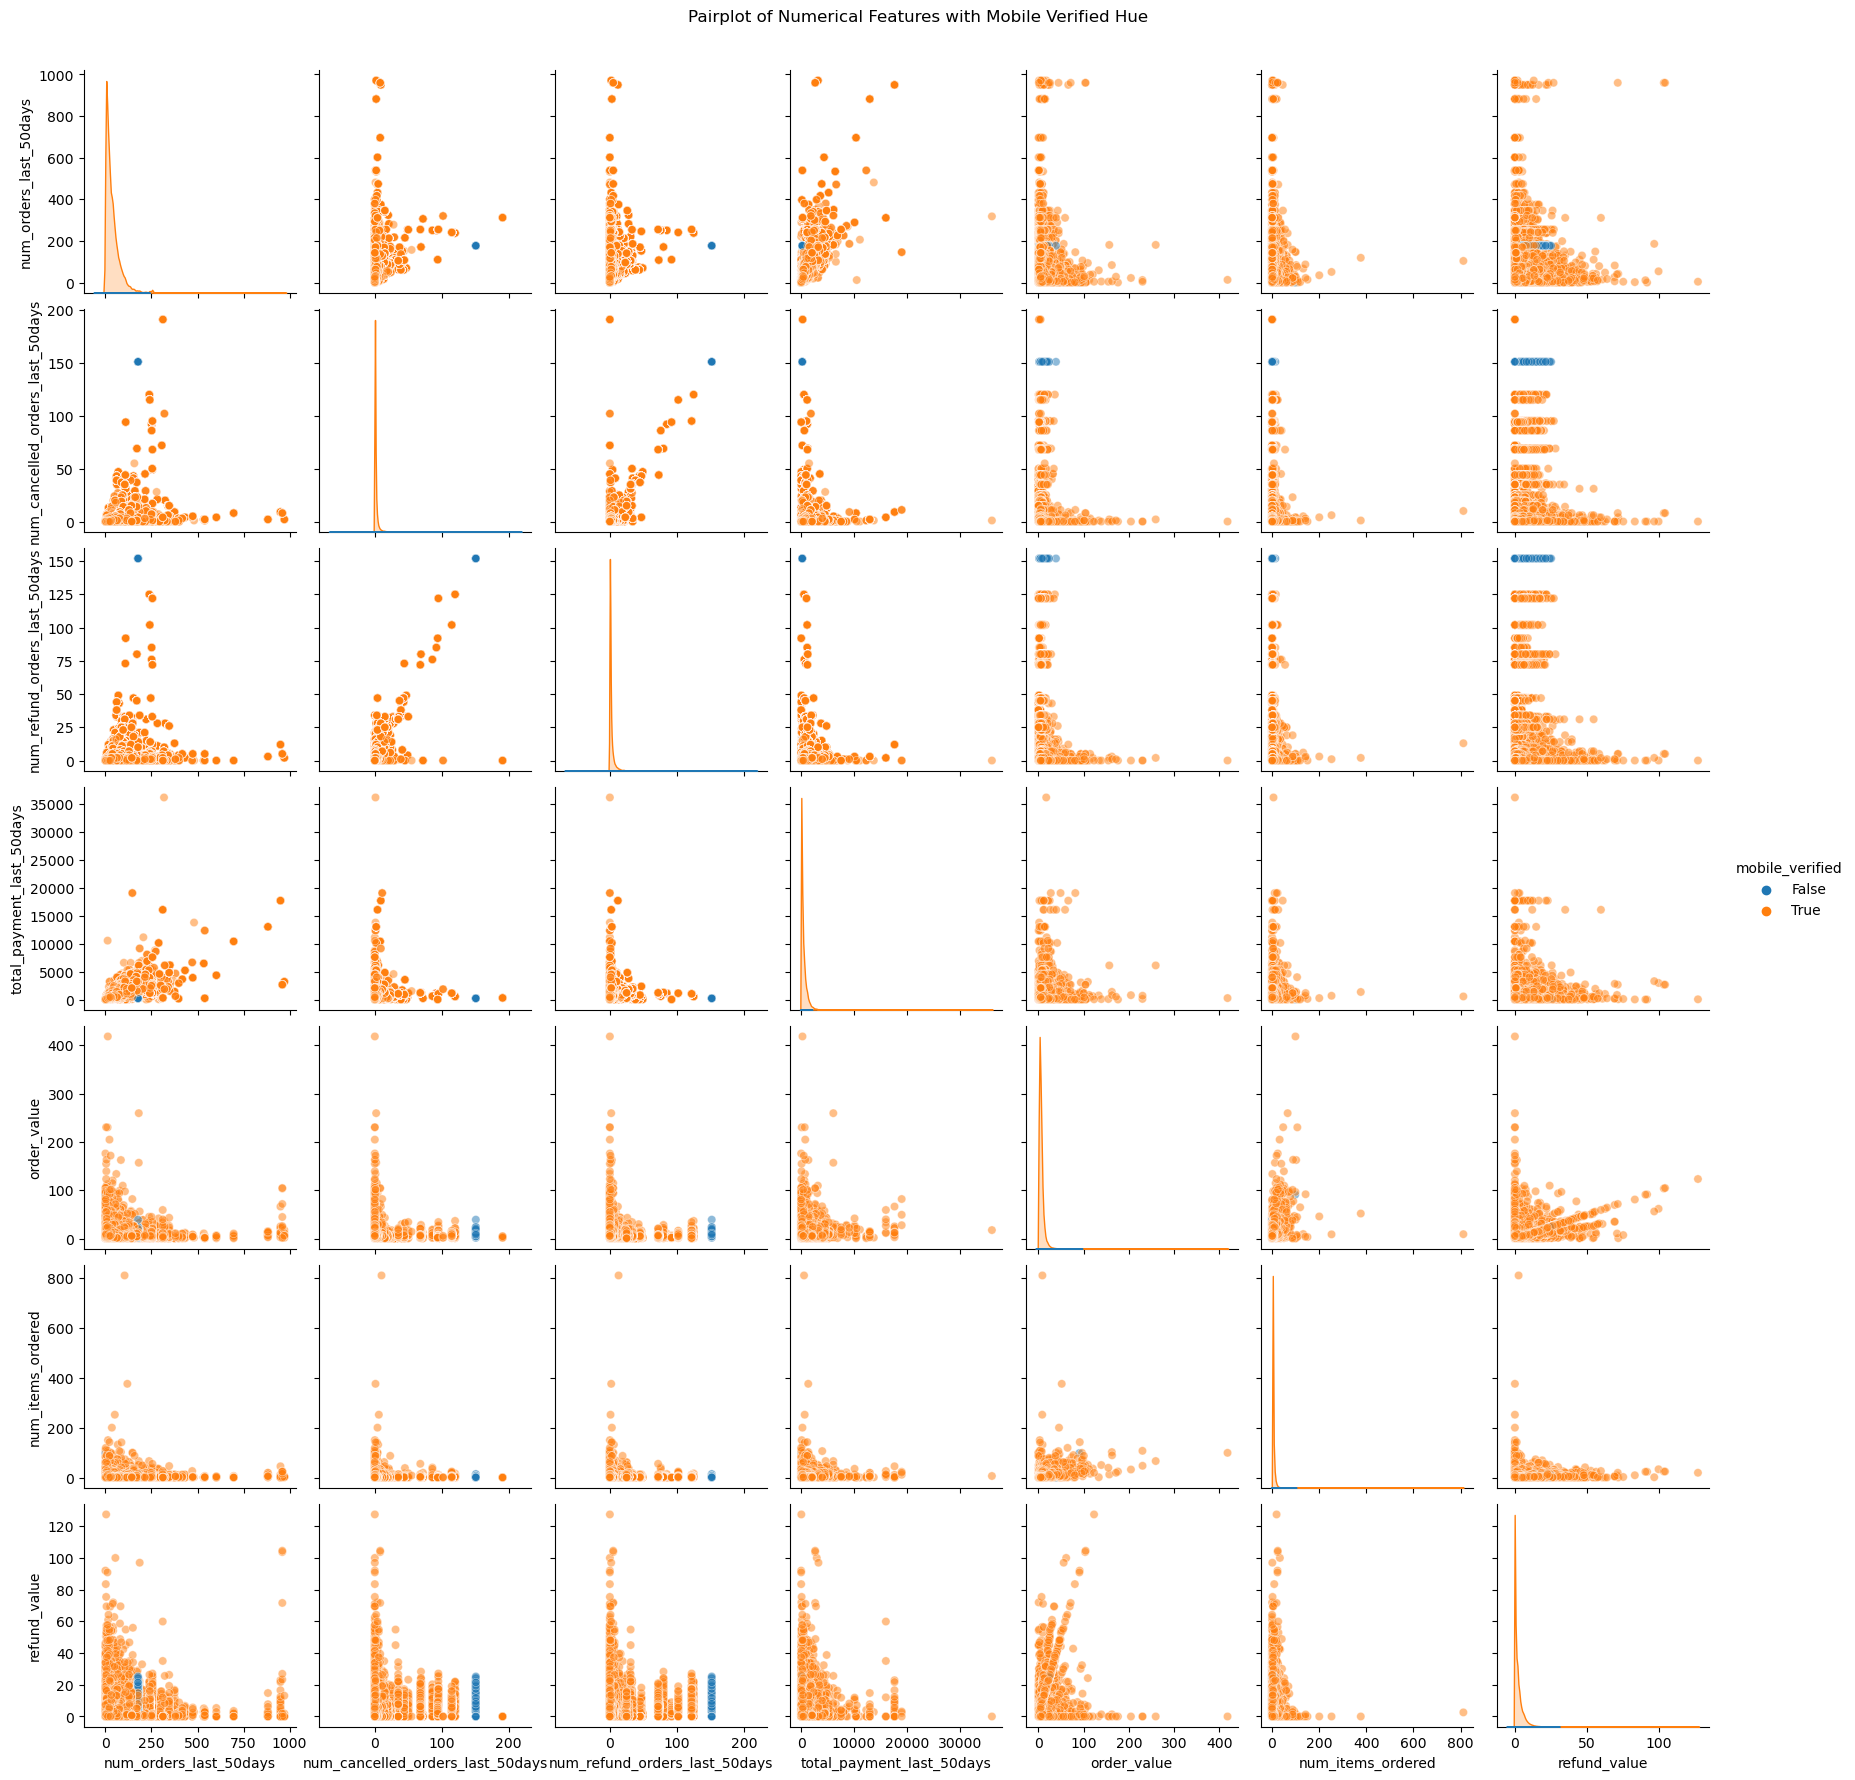

In [24]:
# Select relevant numerical columns
numerical_columns = [
    'num_orders_last_50days', 
    'num_cancelled_orders_last_50days', 
    'num_refund_orders_last_50days', 
    'total_payment_last_50days', 
    'order_value', 
    'num_items_ordered', 
    'refund_value'
]

# Filter the dataset for only the numerical columns
pairplot_data = sp_buy_dataset[numerical_columns]

# Add the `mobile_verified` column to the filtered DataFrame
pairplot_data['mobile_verified'] = sp_buy_dataset['mobile_verified']

# Create a pairplot with hue
sns.pairplot(pairplot_data, hue='mobile_verified', diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Numerical Features with Mobile Verified Hue', y=1.02)  # Add a title above the plot
plt.show()

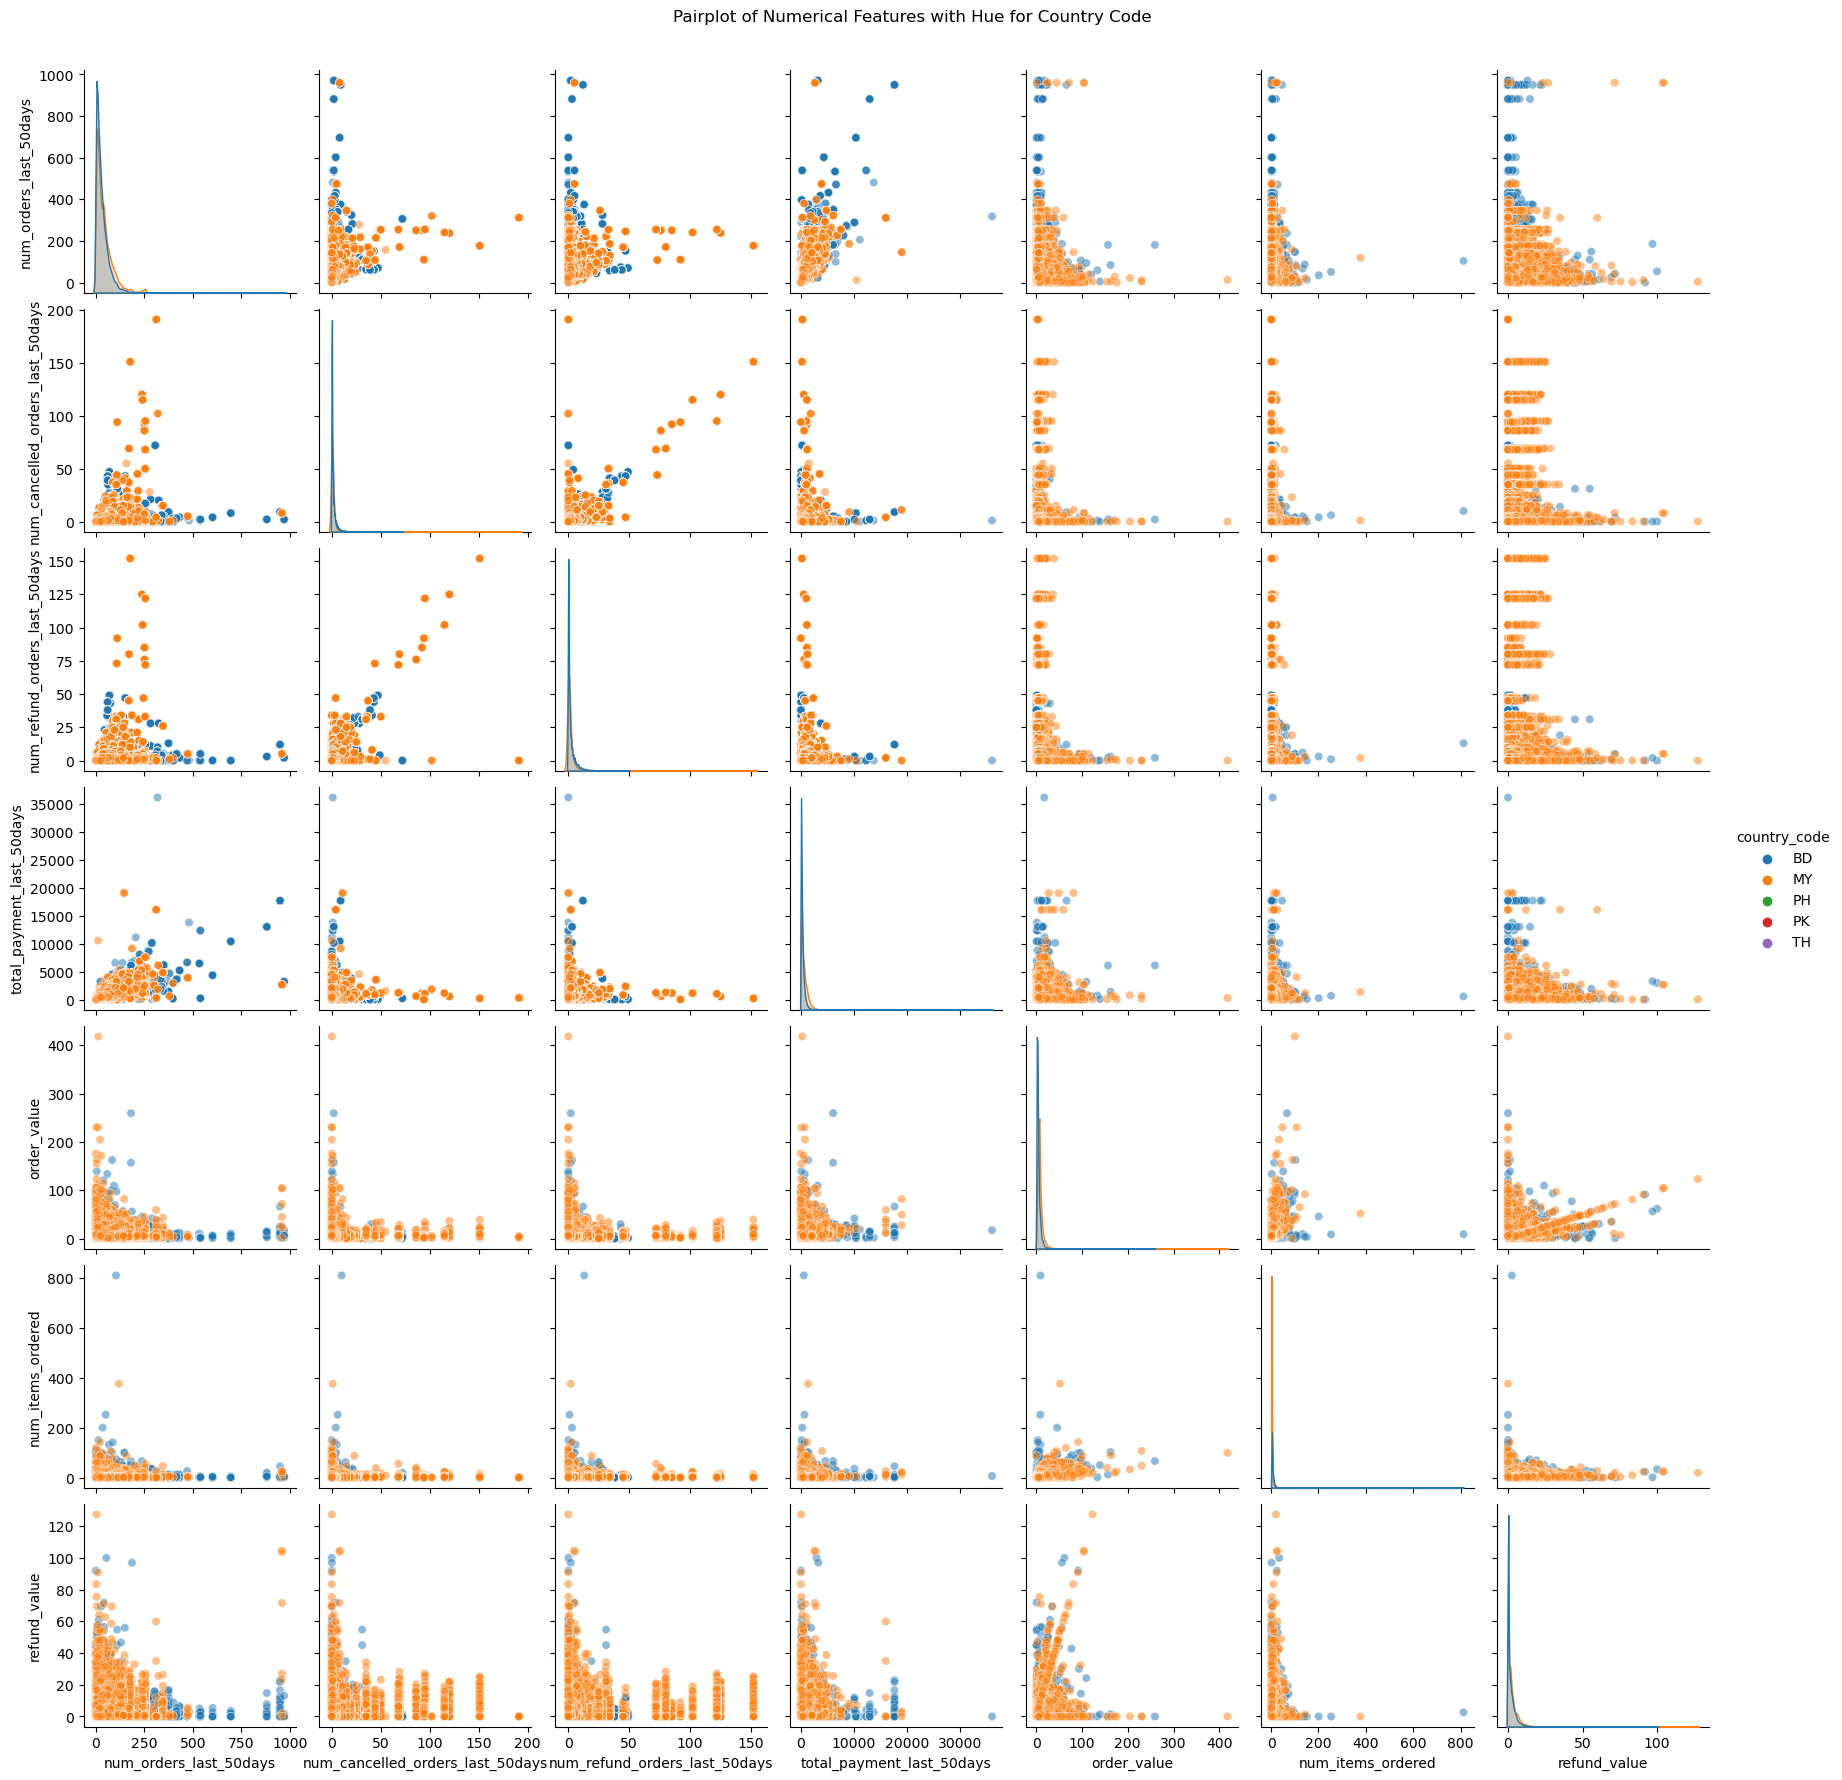

In [25]:
# Select relevant numerical columns
numerical_columns = [
    'num_orders_last_50days', 
    'num_cancelled_orders_last_50days', 
    'num_refund_orders_last_50days', 
    'total_payment_last_50days', 
    'order_value', 
    'num_items_ordered', 
    'refund_value'
]

# Filter the dataset for only the numerical columns, plus the hue column
pairplot_data = sp_buy_dataset[numerical_columns + ['country_code']]

# Create a pairplot with hue for country_code
sns.pairplot(pairplot_data, hue='country_code', diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Numerical Features with Hue for Country Code', y=1.02)  # Add a title above the plot
plt.show()

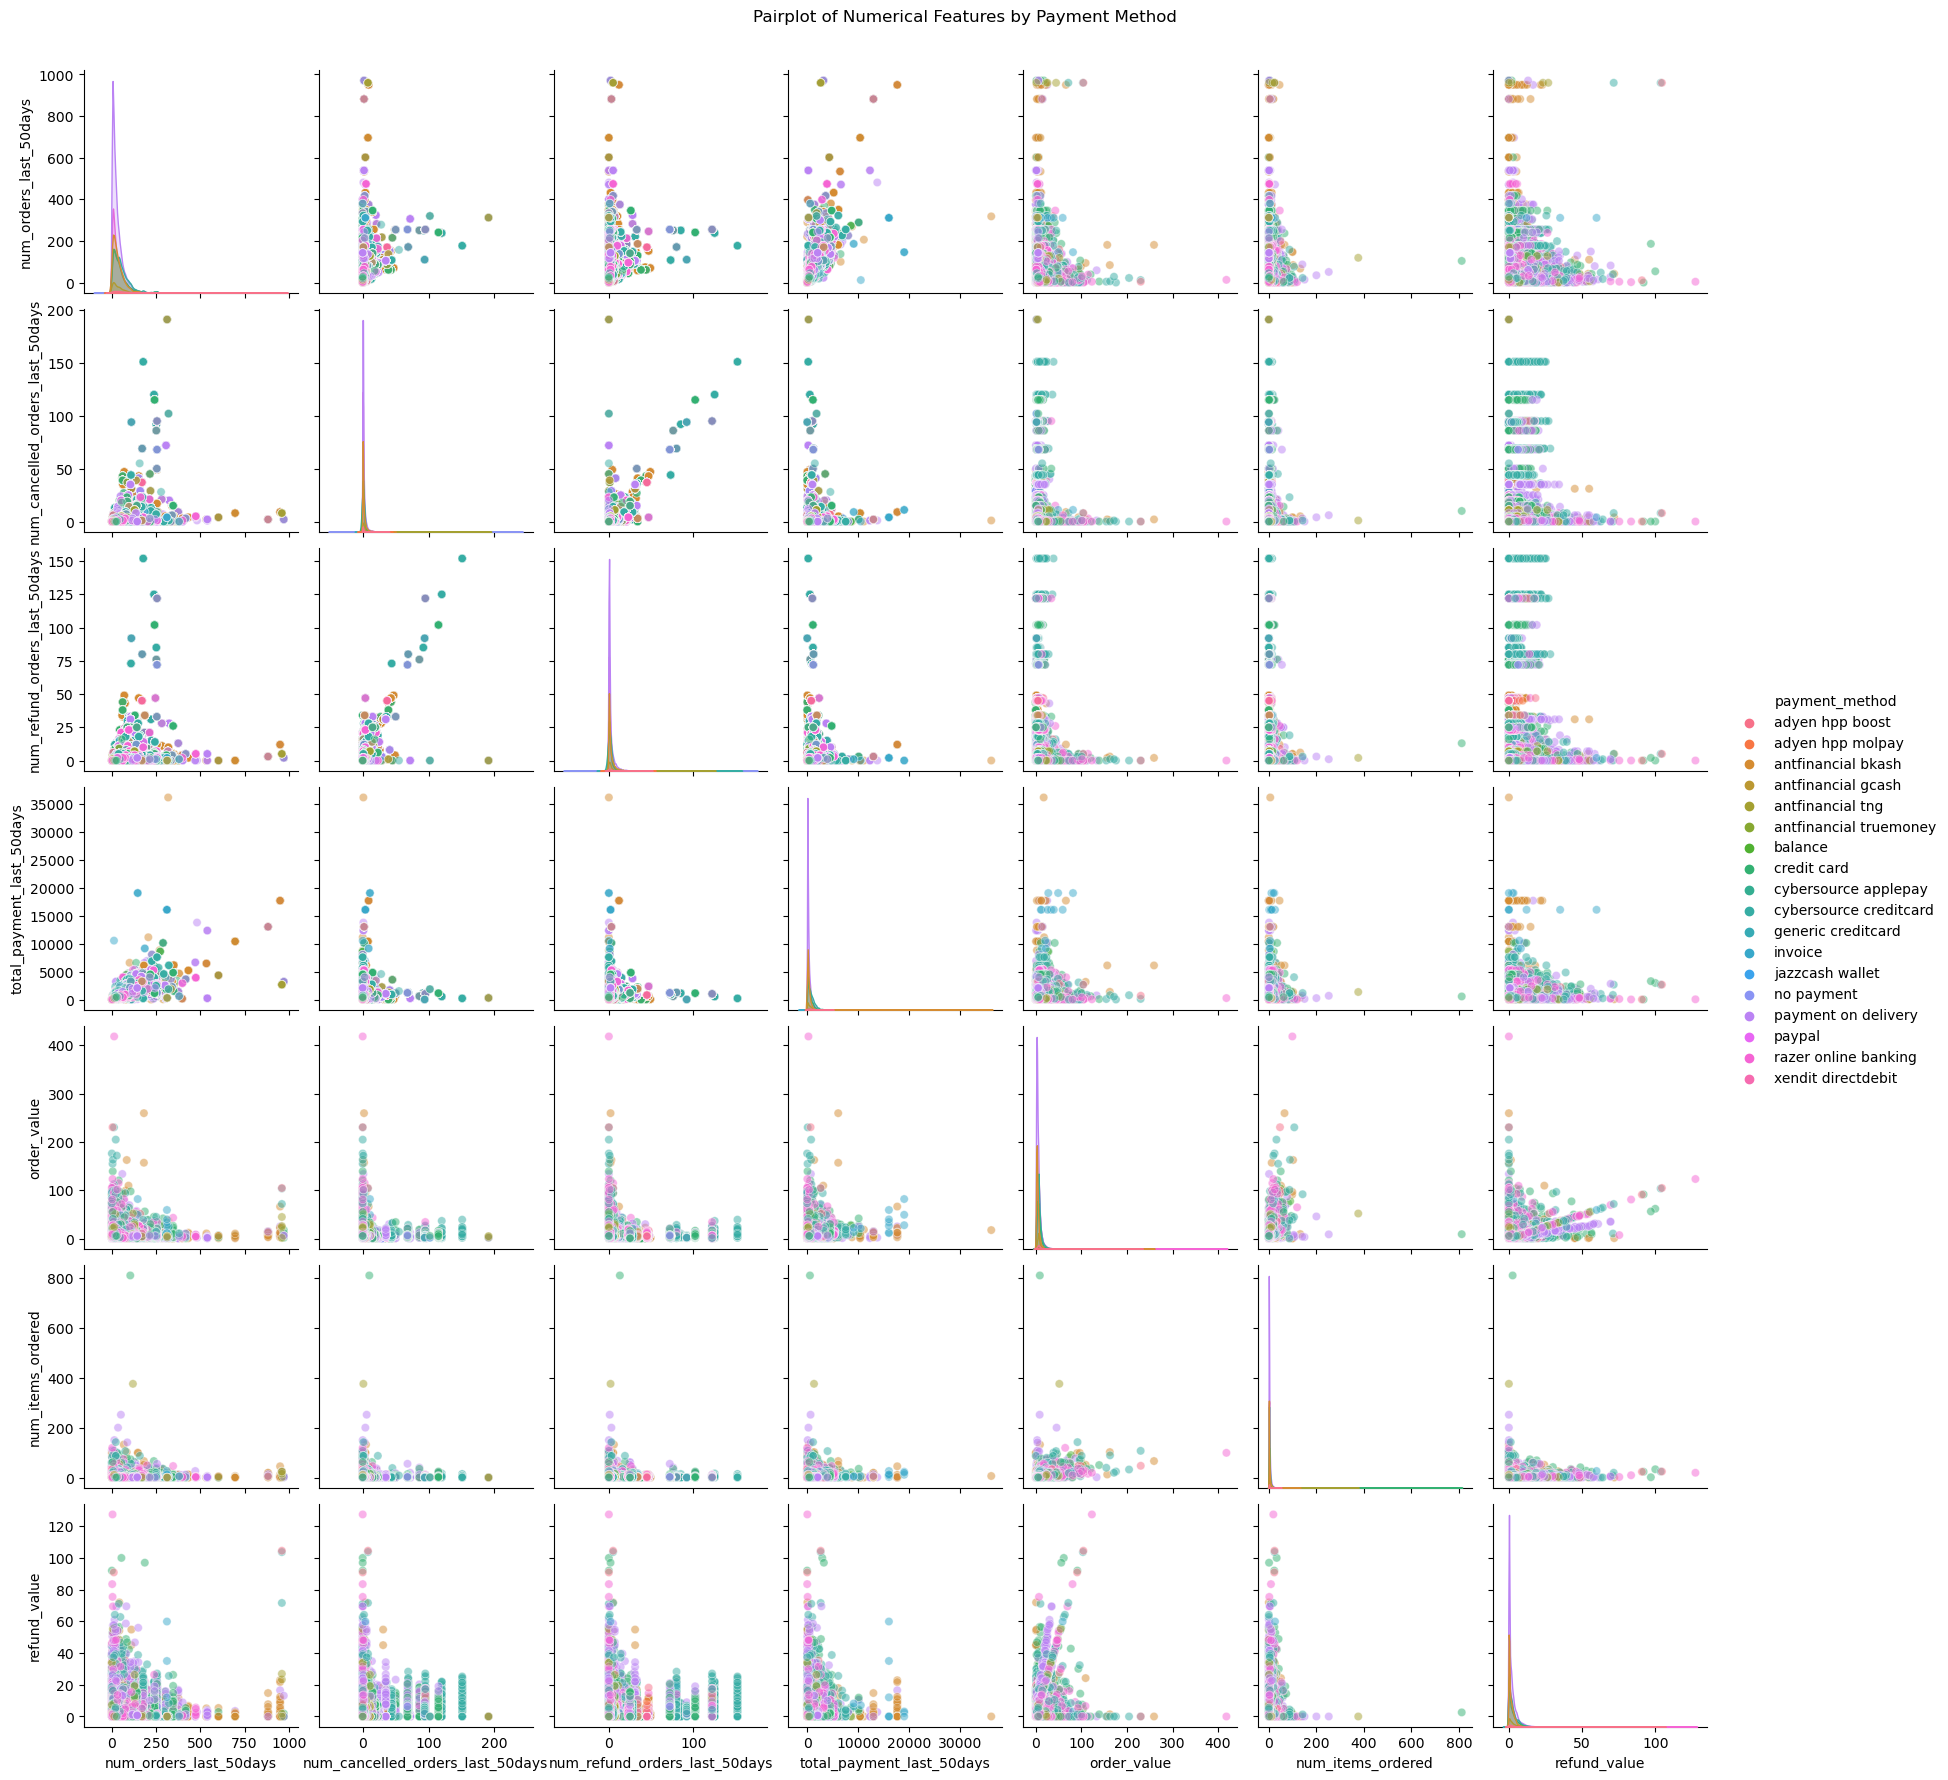

In [26]:
# Select relevant numerical columns
numerical_columns = [
    'num_orders_last_50days', 
    'num_cancelled_orders_last_50days', 
    'num_refund_orders_last_50days', 
    'total_payment_last_50days', 
    'order_value', 
    'num_items_ordered', 
    'refund_value'
]

# Filter the dataset for only the numerical columns
pairplot_data = sp_buy_dataset[numerical_columns]

# Create a pairplot with hue for payment_method
sns.pairplot(sp_buy_dataset, vars=numerical_columns, hue='payment_method', diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Numerical Features by Payment Method', y=1.02)  # Add a title above the plot
plt.show()

<hr>

# **Outlier Detection Techniques**
- `Cluster-based Local Outlier Factor (LOF)`
    - Groups data into clusters, then measures the degree of outlier-ness based on the cluster’s size and the distance of a point to its cluster. Small clusters or points far from large clusters are likely outliers.
    - <u>**Advantages**</u>:
        - Intuitive and interpretable results.
        - Works well for datasets where clustering is meaningful.
    - <u>**Limitations**</u>:
        - Computationally expensive for very large datasets.
        - Requires clustering assumptions to hold (e.g., spherical clusters).
- `Isolation Forest (IF)`
    - This technique explicitly identifies anomalies rather than profiling normal points. It isolates anomalies by randomly selecting a feature and then randomly choosing a split value between the maximum and minimum values of that feature. Anomalies, being few and different, require fewer splits to isolate.
    - <u>**Advantages**</u>:
        - Efficient for large datasets.
        - Handles high-dimensional data well.
    - <u>**Limitations**</u>: 
        - May struggle with overlapping distributions of normal and anomalous data.
- `One-Class SVM`
    - One-Class Support Vector Machines are trained to find a hyperplane that separates the normal data points from the origin (or sparse regions). Points that fall far from this hyperplane are considered anomalies.
    - <u>**Advantages**</u>:
        - Effective in high-dimensional spaces.
        - Suitable for scenarios with only normal data for training.
    - <u>**Limitations**</u>:
        - Computationally expensive for large datasets.
        - Sensitive to parameter tuning and kernel choice.

In [28]:
# Select numerical columns for analysis
numerical_cols = [
    'num_orders_last_50days',
    'num_cancelled_orders_last_50days',
    'num_refund_orders_last_50days',
    'total_payment_last_50days',
    'num_associated_customers',
    'order_value',
    'num_items_ordered',
    'refund_value'
]

# Extract numerical data
df_numeric = sp_buy_dataset[numerical_cols].copy()

# Handle missing values by filling with median
df_numeric.fillna(df_numeric.median(), inplace=True)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

#### 1. Outlier Detection

In [ ]:
classifier_dict = {
    "One-Class SVM": OneClassSVM(nu=0.05, kernel="rbf", gamma='auto'),
    "Isolation Forest": IsolationForest(contamination=0.05, random_state=42),
    "Cluster-based LOF": LocalOutlierFactor(contamination=0.05)
}


# Initialize an empty DataFrame to store outliers
Outliers = pd.DataFrame()

# Iterate through each model and detect outliers
for clf_name, clf in classifier_dict.items():
    if clf_name == "Cluster-based LOF":
        # LOF does not have a separate fit method
        y_pred = clf.fit_predict(X_scaled)
    else:
        clf.fit(X_scaled)
        y_pred = clf.predict(X_scaled)
    
    # -1 for outliers, 1 for inliers
    df_numeric[f'anomaly_{clf_name}'] = y_pred
    outliers_subset = sp_buy_dataset[y_pred == -1].copy()
    outliers_subset = outliers_subset.assign(model=clf_name)
    Outliers = pd.concat([Outliers, outliers_subset], axis=0, ignore_index=True)
print(f"Total outlier detections (including multiple detections for the same data point): {Outliers.shape[0]}")


Total outlier detections (including multiple detections for the same data point): 42445


#### 2. Dimensionality Reduction with PCA

In [30]:
# Apply PCA to the scaled data
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

#### 3. Visualization with Marker Outline

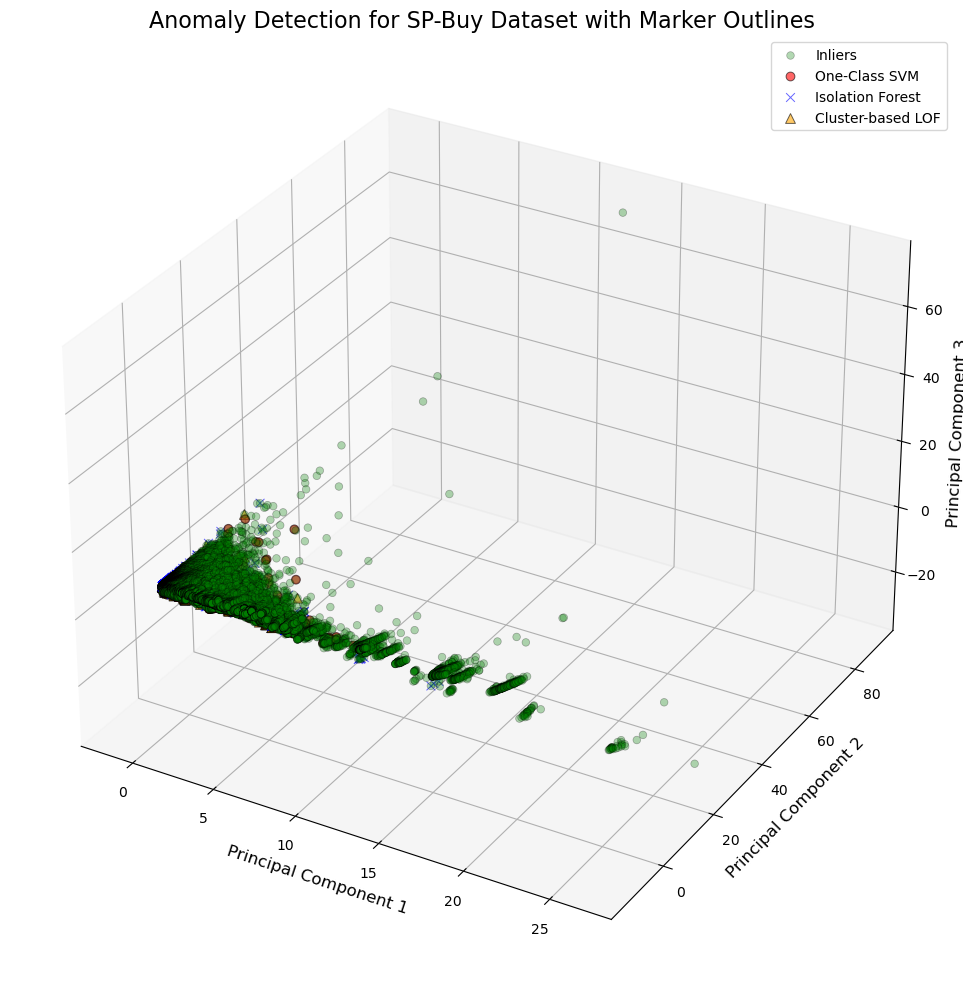

In [31]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot inliers with an outline
ax.scatter(
    pca_df['PC1'],
    pca_df['PC2'],
    pca_df['PC3'],
    s=30,
    c='green',
    label='Inliers',
    alpha=0.3,
    edgecolor='black',  # Add an outline
    linewidths=0.5      # Set outline width
)

# Define colors and markers for each outlier detection model
model_styles = {
    "One-Class SVM": {"color": "red", "marker": "o", "label": "One-Class SVM"},
    "Isolation Forest": {"color": "blue", "marker": "x", "label": "Isolation Forest"},
    "Cluster-based LOF": {"color": "orange", "marker": "^", "label": "Cluster-based LOF"}
}

# Plot outliers for each model with an outline
for model, style in model_styles.items():
    # Get indices of outliers detected by the current model
    outlier_subset = Outliers[Outliers['model'] == model]
    outlier_indices = outlier_subset.index.unique()
    
    # Set a larger marker size for the "Cluster-based LOF" model
    marker_size = 50 if model == "Cluster-based LOF" else 40
    
    # Extract PCA components for these indices
    ax.scatter(
        pca_df.loc[outlier_indices, 'PC1'],
        pca_df.loc[outlier_indices, 'PC2'],
        pca_df.loc[outlier_indices, 'PC3'],
        s=marker_size,
        c=style['color'],
        marker=style['marker'],
        label=style['label'],
        edgecolor='black',  # Add an outline
        linewidths=0.7,     # Set outline width
        alpha=0.6
    )

# Set labels and title
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.set_zlabel('Principal Component 3', fontsize=12)
plt.title("Anomaly Detection for SP-Buy Dataset with Marker Outlines", fontsize=16)

# Add legend
plt.legend(loc='best')
plt.tight_layout()
plt.show()

<u>**Observations**</u>
- Inliers (Green Dots): The majority of the data points are classified as inliers and are densely packed in a specific region.
- One-Class SVM (Red Circles): The detected anomalies seem to be spread across the data, indicating that this method is capturing some global anomalies but might not be ideal for large-scale datasets due to its computational complexity.
- Isolation Forest (Blue Xs): This method detects outliers in more extreme locations of the dataset. It is well-known for being efficient with large datasets and is commonly used in fraud detection.
- Cluster-based LOF (Yellow Triangles): This method captures localized anomalies, meaning it identifies outliers based on their deviation from neighboring clusters.

<u>**Conclusions**</u>
- `Isolation Forest` is the best choice for large fraud detection datasets
    - It is highly scalable and efficient for big data.
    - It works well with high-dimensional data.
    - It detects anomalies based on their separation from the normal data distribution.
    - It does not require the dataset to be labeled.

<hr>

# **Imbalanced Classes**
- `Data-Level Methods`
    - <u>**Oversampling**</u>:
        - Synthetic Minority Over-Sampling Technique (SMOTE): Generates synthetic examples by interpolating between existing minority class samples.
        - ADASYN: An extension of SMOTE that generates synthetic samples more adaptively, focusing on hard-to-classify samples.
        - Random Oversampling: Repeats minority class samples to balance class distribution.
    - <u>**Undersampling**</u>:
        - Random Undersampling: Removes majority class samples to balance the data.
        - Tomek Links: Removes overlapping samples between classes to clean the decision boundary.
        - Edited Nearest Neighbors (ENN): Eliminates samples whose labels disagree with their k-nearest neighbors.
- `Algorithm-Level Methods`
    - <u>**Cost-Sensitive Learning**</u>:
        - Assigns higher misclassification costs to minority class samples, making them more important to the model.
        - Example: Cost-sensitive SVMs, cost-sensitive decision trees.
    - <u>**Ensemble Techniques**</u>:
        - Balanced Random Forest (BRF): Modifies random forest to use balanced bootstrap samples for each tree.
        - EasyEnsemble: Uses multiple random undersampled subsets of the majority class to train individual classifiers.
        - XGBoost with Scale-Pos-Weight: Adjusts the weight for the positive class in the objective function.
    - <u>**Class Prior Modification**</u>:
        - Adjusts the decision threshold or modifies priors during classification to favor the minority class.
- `Hybrid Methods`
    - SMOTEBoost combines SMOTE with boosting algorithms to address imbalance while improving predictive performance.

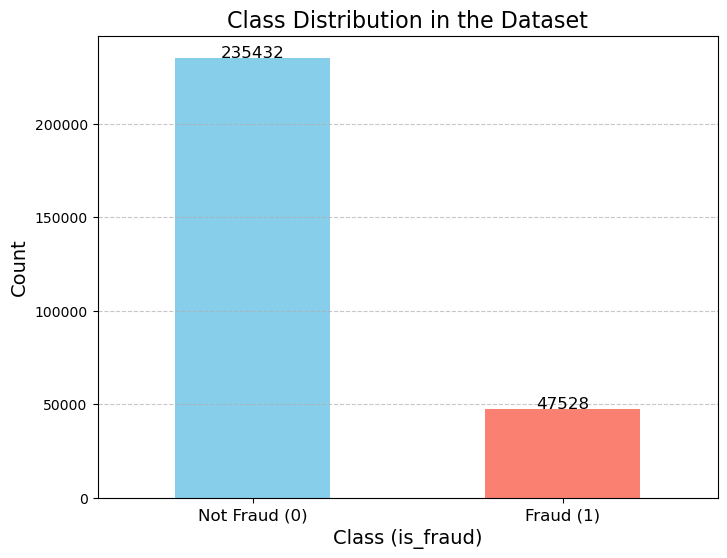

In [32]:
# Count the number of occurrences for each class in the 'is_fraud' column
class_counts = sp_buy_dataset['is_fraud'].value_counts()

# Plot a bar chart to visualize class imbalance
plt.figure(figsize=(8, 6))
bars = class_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Add the counts on top of the bars
for i, count in enumerate(class_counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=12)

plt.title('Class Distribution in the Dataset', fontsize=16)
plt.xlabel('Class (is_fraud)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Not Fraud (0)', 'Fraud (1)'], rotation=0, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **Testing Different Techniques with Baseline Model**

In [6]:
def prepare_data(df):
    print("Preparing data...")
    # Create a copy to avoid modifying the original dataframe
    df_processed = df.copy()
    
    # List of numeric columns to keep
    numeric_cols = [
        'num_orders_last_50days',
        'num_cancelled_orders_last_50days',
        'num_refund_orders_last_50days',
        'num_associated_customers',
        'total_payment_last_50days',
        'num_items_ordered',
        'order_value',
        'refund_value'
    ]
    
    # List of categorical columns to encode
    categorical_cols = [
        'country_code',
        'collect_type',
        'payment_group'
    ]
    
    # Boolean columns
    boolean_cols = ['mobile_verified']
    
    # Initialize label encoders for categorical columns
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
        df_processed[col] = label_encoders[col].fit_transform(df_processed[col])
    
    # Convert boolean columns to int
    for col in boolean_cols:
        df_processed[col] = df_processed[col].astype(int)
    
    # Combine all feature columns
    feature_cols = numeric_cols + categorical_cols + boolean_cols
    
    # Create feature matrix X and target vector y
    X = df_processed[feature_cols]
    y = df_processed['is_fraud']
    
    # Scale numeric features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns
    )
    
    return train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#### **Baseline Model** (`DecisionTreeClassifier`)

In [7]:
def evaluate_technique(X_train, X_test, y_train, y_test, technique_name, resampler=None):
    start_time = time.time()
    
    # Apply resampling if specified
    if resampler is not None:
        X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)
    else:
        X_resampled, y_resampled = X_train, y_train
    
    # Initialize and train the classifier
    clf = DecisionTreeClassifier(random_state=42)
    
    # Get cross-validation scores
    scoring = {
        'accuracy': 'accuracy',
        'balanced_accuracy': 'balanced_accuracy',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    
    scores = cross_validate(
        clf,
        X_resampled,
        y_resampled,
        scoring=scoring,
        cv=5,
        return_train_score=True
    )
    
    # Calculate timing
    fit_time = scores['fit_time'].mean()
    score_time = scores['score_time'].mean()
    
    # Prepare results
    results = {
        'fit_time': fit_time,
        'score_time': score_time,
        'test_accuracy': scores['test_accuracy'].mean(),
        'train_accuracy': scores['train_accuracy'].mean(),
        'test_balanced_accuracy': scores['test_balanced_accuracy'].mean(),
        'train_balanced_accuracy': scores['train_balanced_accuracy'].mean(),
        'test_recall': scores['test_recall'].mean(),
        'train_recall': scores['train_recall'].mean(),
        'test_f1': scores['test_f1'].mean(),
        'train_f1': scores['train_f1'].mean(),
        'test_roc_auc': scores['test_roc_auc'].mean(),
        'train_roc_auc': scores['train_roc_auc'].mean()
    }
    
    return pd.Series(results, name=technique_name)

In [8]:
def compare_techniques(df):
    # Prepare data
    X_train, X_test, y_train, y_test = prepare_data(df)
    print("Data preparation complete.")
    
    # Define resampling techniques
    techniques = {
        'Baseline': None,
        'SMOTE': SMOTE(random_state=42),
        'ADASYN': ADASYN(random_state=42),
        'RandomOverSampler': RandomOverSampler(random_state=42),
        'RandomUnderSampler': RandomUnderSampler(random_state=42),
        'SMOTETomek': SMOTETomek(random_state=42),
        'SMOTEENN': SMOTEENN(random_state=42)
    }
    
    # Evaluate each technique
    results = []
    pbar = tqdm(total=len(techniques), desc="Evaluating techniques")
    for name, technique in techniques.items():
        result = evaluate_technique(X_train, X_test, y_train, y_test, name, technique)
        results.append(result)
        pbar.update(1)
    pbar.close()
    
    # Combine results
    results_df = pd.concat(results, axis=1).T
    
    # Style the output
    styled_df = results_df.style.apply(
        lambda x: ["background-color: red; color: white" if v else "" for v in x == x.min()]
    ).apply(
        lambda x: ["background-color: green; color: white" if v else "" for v in x == x.max()]
    )
    
    return styled_df

In [14]:
results = compare_techniques(sp_buy_dataset)
display(results)

Preparing data...
Data preparation complete.


Evaluating techniques: 100%|██████████| 7/7 [30:24<00:00, 260.60s/it]


,fit_time,score_time,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
Baseline,1.649916,0.087400,0.959561,0.999859,0.858102,0.999199,0.738702,0.998423,0.732958,0.999059,0.858744,1.000000
SMOTE,7.768409,0.188672,0.972860,0.999922,0.972860,0.999922,0.973071,0.999885,0.972583,0.999922,0.972905,1.000000
ADASYN,6.660946,0.179831,0.962883,0.999922,0.962860,0.999922,0.953509,0.999885,0.961988,0.999922,0.962957,1.000000
RandomOverSampler,3.940392,0.205917,0.988251,0.999900,0.988251,0.999900,1.000000,1.000000,0.988388,0.999900,0.988281,1.000000
RandomUnderSampler,0.296385,0.020349,0.914950,0.999938,0.914950,0.999938,0.914376,0.999900,0.914897,0.999938,0.915063,1.000000
SMOTETomek,6.511621,0.163970,0.974263,0.999921,0.974263,0.999921,0.974300,0.999884,0.974003,0.999921,0.974308,1.000000
SMOTEENN,5.060368,0.136195,0.988370,1.000000,0.988354,1.000000,0.988895,1.000000,0.988672,1.000000,0.988354,1.000000


<u>**Observations**</u>
- Best Overall Performance: `SMOTEENN` shows consistently strong performance across most metrics:
    - Perfect training accuracy (1.000000)
    - Highest test balanced accuracy (0.988354)
    - Perfect training balanced accuracy
    - High test recall (0.988895)
    - Perfect train recall and F1 scores
    - Excellent ROC AUC scores
- Efficiency:
    - RandomUnderSampler is the fastest in terms of fit_time (0.296385)
    - However, its performance metrics are generally lower than other techniques
- Interesting Trade-offs:
    - RandomOverSampler achieves perfect recall (1.000000) and perfect train F1 score
    - SMOTE shows very balanced performance across all metrics without any significant weaknesses
    - Baseline model shows decent accuracy but lower balanced accuracy, indicating potential bias towards the majority class
- Processing Time:
    - SMOTE takes the longest processing time (7.768409)
    - SMOTEENN and SMOTETomek offer good balance between processing time and performance

<u>**Conclusions**</u>
- We will be using `SMOTEENN` to train our final model:
    - It provides the most balanced performance across all metrics
    - Shows excellent generalization (similar test and train scores)
    - Achieves perfect scores in several key metrics while maintaining high performance in others
    - Processing time (5.060368) is reasonable compared to other high-performing techniques
    - Shows no significant weaknesses across any metrics